## AskWhai Data Challenge
## Devanshi Mittal - April 2019


In [422]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
#from pandas.stats.plm import PanelOLS
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
pd.set_option("display.max_rows",20)

In [424]:
#Importing the data
payments = pd.read_csv('~/payments.csv')

## 1. Take an initial look at the Payments dataset in order to understand each column. You may use the description of the dataset on the City of Chicago data portal, as well as direct examination of the data. Discuss any issues you identify with data quality, or other factors that may complicate further analysis. How could you potentially mitigate these issues?

Potential Problems:

1. Check Date: The Check Date format is not consistent in the data. 

Also since the data from 1996-2002 is mentioned as data from 2002, it must be important to decide whether to include or not include the data points where date = 2002 as it gives wrong information for year 2002.

2. Contract Number: Contract Number should be a number as the name suggests but it is not so.

3. Voucher Number: There is a category called Multiple here which may make the analysis more complicated.

Apart from these issues, the dataset (especially the Department Name dataset) contains a very large number of missing values which may complicate analysis if used.

1. To Keep the Check Date format consistent, we convert the the Check Date column to datetime objects. 

Since all the date points may come handy, we create three columns of year, month and date.

In [425]:
payments["CHECK DATE"] = pd.to_datetime(payments["CHECK DATE"])
payments["CHECK DATE YEAR"] = payments["CHECK DATE"].dt.year
payments["CHECK DATE MONTH"] = payments["CHECK DATE"].dt.month
payments["CHECK DATE DAY"] = payments["CHECK DATE"].dt.day

Since the data from 1996-2002 is treated as year 2002, I make the design decision here to remove the data points that have year 2002.

In [426]:
payments = payments[payments["CHECK DATE YEAR"] != 2002]

2. It can be observed below that the count of DV values is much higher than for any other Contract Number value.
Hence I make this design decision that creates a new column - DV OR NOT - where if the contract number is dv, it marks the value as 1 else 0. It does not rule out the problem of the contract number being a number but it makes further analysis simpler.

In [427]:
payments['CONTRACT NUMBER'].value_counts()

DV             545004
33233            4617
19393            1452
28775            1411
24027             733
47144             683
28296             681
33232             676
28295             610
30545             571
                ...  
D2961206040         1
C029661C            1
50616               1
39279               1
56463               1
46189               1
64684               1
38684               1
40565               1
37184               1
Name: CONTRACT NUMBER, Length: 49915, dtype: int64

In [428]:
payments['DV OR NOT'] = np.where(payments['CONTRACT NUMBER'] == 'DV',1, 0)

3. To deal with the category 'Multiple' of Voucher Number, I made another design decision which does not take that into consideration.



In [429]:
payments = payments[payments["VOUCHER NUMBER"] != 'Multiple']


In [430]:
payments.nunique()

VOUCHER NUMBER      176785
AMOUNT              173969
CHECK DATE             348
DEPARTMENT NAME         49
CONTRACT NUMBER      49915
VENDOR NAME         344273
CASHED                   2
CHECK DATE YEAR         17
CHECK DATE MONTH        12
CHECK DATE DAY          31
DV OR NOT                2
dtype: int64

These unique values tell us what features to use - the lesser the unique values, the better will the model be able to use those features to predict. Department Name, DV or not, Day, Month and Year are some of the few features that can be used.

## 2. Tell us about some interesting insights you might be able to gain from this data after an appropriate analysis. Consider descriptive, predictive, and prescriptive tasks alike. What would you want the data to tell you, and what are some techniques you could use to achieve those goals?


Let's see the count of Cashed and Non-Cashed Values.

Text(0.5, 1.0, 'Count of Cashed and Non Cashed Values')

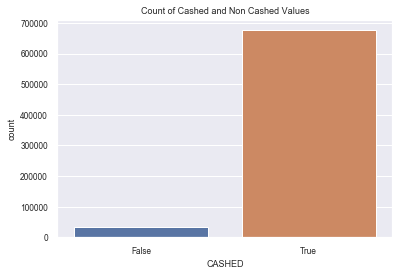

In [431]:
sns.countplot(payments["CASHED"]).set_title('Count of Cashed and Non Cashed Values')

Exploring the DV or not values.

Text(0.5, 1.0, 'Count of Direct Voucher and Non Direct Voucher Values')

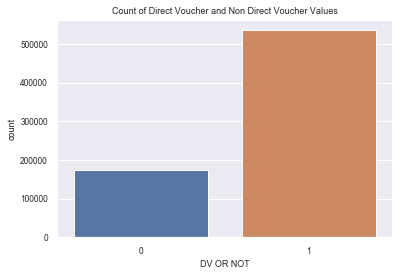

In [432]:
sns.countplot(payments['DV OR NOT']).set_title('Count of Direct Voucher and Non Direct Voucher Values')

It is important to see the yearwise total and average payments to understand how it has changed over the years.
There is a sharp increase from year 2009 to 2010 and the total payments have been consistently increasing.

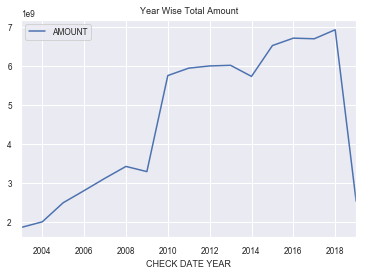

In [433]:
yearwise_totalpayments = payments.groupby(['CHECK DATE YEAR']).sum().reset_index()
yearwise_totalpayments.plot(x = 'CHECK DATE YEAR', y = 'AMOUNT', title="Year Wise Total Amount")

On observing the average amount over the years, it can be seen that the average amount becomes much lower which means that the number of payments have increased.

This conclusion is under the assumption that this data has been appropriately recording the payments since 2002 and there is no payment which hasn't been recorded. 

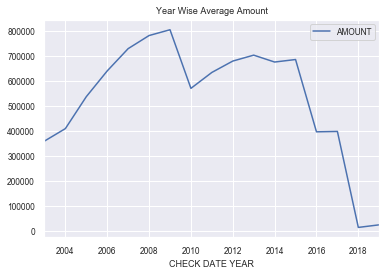

In [434]:
yearwise_avgpayments = payments.groupby(['CHECK DATE YEAR']).mean().reset_index()
yearwise_avgpayments.plot(x = 'CHECK DATE YEAR', y = 'AMOUNT', title="Year Wise Average Amount")

To further confirm, it can be seen that there is a huge spike in the number of payments from 2018 which may be due to a large number of small transactions which was not true for the previous years.

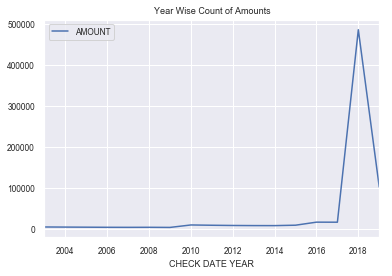

In [435]:
yearwise_countpayments = payments.groupby(['CHECK DATE YEAR']).count().reset_index()
yearwise_countpayments.plot(x = 'CHECK DATE YEAR', y = 'AMOUNT', title="Year Wise Count of Amounts")

In [440]:
counts_dv_or_not = payments.groupby(['CHECK DATE YEAR','DV OR NOT']).count()
cashed_or_not = payments.groupby(['CHECK DATE YEAR','CASHED']).count()

As can be observed below, the data points are a lot for years 2018 and 2019 for the both the variables - "CASHED" and "DV OR NOT".

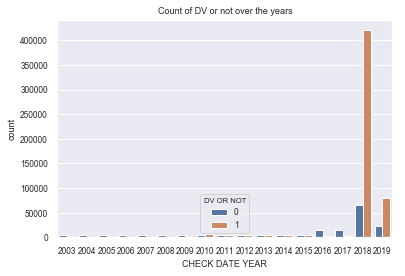

In [437]:
sns.set(font_scale=0.75)
ax = sns.countplot(x='CHECK DATE YEAR', hue='DV OR NOT', data=payments).set_title("Count of DV or not over the years")

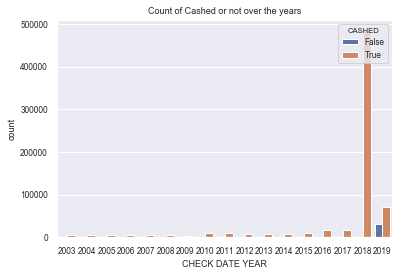

In [438]:
sns.set(font_scale=0.75)
ax = sns.countplot(x='CHECK DATE YEAR', hue='CASHED', data=payments).set_title("Count of Cashed or not over the years")

## 3. Choose two different insights to focus on which demand different methods (e.g. k-means clustering and classification trees), and complete an analysis of the data columns which you believe will contribute to those insights. This does not need to be a “perfect” analysis, but you must provide the full code involved in your process.

There are two parts to this analysis that I did.

1) Using Supervised Learning to predict whether the transaction will be cashed or not and predict whether the transaction is a DV or not.

There are many issues to doing this:
a) The data is highly imbalanced when taking Cashed column as the target column and hence I considered predicting DV or not as well.
b) There are too many unique values for Vendor Name and Voucher Number which does not make it a useful feature.

Hence for this analysis we use the features - Year, Month, Day, Amount, DV or Not and Department Names to predict the target variable.

2) Since this is an open-ended problem, this data could help identify similar data points. Hence I tried using unsupervised - K-means clustering method that could help cluster and give some insights for further analysis.

### Predict whether transaction is DV or not

The independent variables used are Year, Month, Day, Amount, Cashed Or Not and the Department Name.

XGBoost Classifier  is an implementation of gradient boosted decision trees.
The scale_pos_weight parameter helps deal with unbalanced data by considering a value like sum(negative instances) / sum(positive instances).

In [368]:
#onehot encoding for Cashed variable to use in xgBoost.
payments_onehot = pd.get_dummies(payments, columns=['CASHED'])
#onehot encoding for Department Name variable to use in xgBoost.
payments_onehot = pd.get_dummies(payments_onehot, columns=['DEPARTMENT NAME'])
y = payments_onehot['DV OR NOT']
X = payments_onehot.drop(['DV OR NOT','CONTRACT NUMBER', 'VENDOR NAME', 'VOUCHER NUMBER', 'CHECK DATE'], axis=1)
y=y.astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
cv_scores = cross_val_score(xgb1, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
xgb1.fit(X_train, y_train)
# feature importance
# Use the forest's predict method on the test data
predictions = xgb1.predict(X_test)
# Calculate the absolute errors
print(classification_report(y_test, predictions))

[0.95064629 0.9525605  0.95310189 0.95111953 0.95352637]
cv_scores mean:0.9521909146094168
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     61041
           1       0.97      0.97      0.97    160609

   micro avg       0.95      0.95      0.95    221650
   macro avg       0.94      0.94      0.94    221650
weighted avg       0.95      0.95      0.95    221650



On cross validating, we can see that the model performs equally well overall and we are not overfitting.

It can be seen that the weighted F-1 score obtained on the test set is very good (0.95) which means that the overall model is really good.

I tried implementing logistic regression and random forest models on the same but the above model gave the best results.

### Predict whether transaction is cashed or not

The independent variables used are Year, Month, Day, Amount, DV Or Not and the Department Name.

XGBoost Classifier is an implementation of gradient boosted decision trees.
The scale_pos_weight parameter helps deal with unbalanced data 

In [370]:
payments_onehot = pd.get_dummies(payments, columns=['DV OR NOT'])
payments_onehot = pd.get_dummies(payments_onehot, columns=['DEPARTMENT NAME'])
y = payments_onehot['CASHED']
X = payments_onehot.drop(['CASHED','CONTRACT NUMBER', 'VENDOR NAME', 'VOUCHER NUMBER', 'CHECK DATE'], axis=1)
y=y.astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
cv_scores = cross_val_score(xgb1, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
xgb1.fit(X_train, y_train)
# feature importance
# Use the forest's predict method on the test data
predictions = xgb1.predict(X_test)
# Calculate the absolute errors
print(classification_report(y_test, predictions))

[0.96494485 0.96405542 0.96470281 0.96394872 0.96355234]
cv_scores mean:0.9642408271776537
              precision    recall  f1-score   support

       False       0.56      0.82      0.67      9865
        True       0.99      0.97      0.98    211785

   micro avg       0.96      0.96      0.96    221650
   macro avg       0.78      0.89      0.82    221650
weighted avg       0.97      0.96      0.97    221650



On cross validating, we can see that the model performs equally well overall and we are not overfitting.

It can be seen that the weighted F-1 score obtained on the test set is very good (0.97), however it is important to note that the precision rate for predicting that a transaction will be Cash or Not is really bad. This may be due to the very less number of 'False' values in the dataset.

I tried implementing logistic regression and random forest models on the same but the above model gave the best results.

### Unsupervised Learning Through K-Means Clustering.

K-means clustering basically clusters all similar datapoints together. 

In this given dataset, we have very few numerical features that can be used as compared to categorical variables.

I implement K-means clustering to two types of data according to the years.
This is because the type of datapoints for 2018 and 2019  are very different from the rest of the years which may negate the effect of the years that have less datapoints.

1) payments_1819 - contains only years 2018 and 2019.
2) payments_not1819 - does not contain years 2018 and 2019.

In [406]:
payments_1819 = payments.loc[(payments['CHECK DATE YEAR'] >= 2018) & (payments['CHECK DATE YEAR'] <= 2019)]
payments_onehot = pd.get_dummies(payments_1819, columns=['DV OR NOT'])
payments_onehot = pd.get_dummies(payments_onehot, columns=['CASHED'])
payments_onehot = pd.get_dummies(payments_onehot, columns=['DEPARTMENT NAME'])
X = payments_onehot.drop(['CONTRACT NUMBER', 'VENDOR NAME', 'VOUCHER NUMBER', 'CHECK DATE'], axis=1)

In [407]:
Kmean = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
#Kmean.cluster_centers_.shape
#Kmean.labels_

In [408]:
y_kmeans = Kmean.fit_predict(X)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
X['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(X.groupby('cluster').mean(),1))
kmeans_mean_cluster

,AMOUNT,CHECK DATE YEAR,CHECK DATE MONTH,CHECK DATE DAY,DV OR NOT_0,DV OR NOT_1,CASHED_False,CASHED_True,DEPARTMENT NAME_CHICAGO DEPARTMENT OF TRANSPORTATION,DEPARTMENT NAME_CHICAGO PUBLIC LIBRARY,...,DEPARTMENT NAME_DEPT OF STREETS & SANITATION,DEPARTMENT NAME_FIRE DEPARTMENT,DEPARTMENT NAME_GRAPHICS & REPRODUCTION CTR,DEPARTMENT NAME_OFFICE FOR PEOPLE WITH DISABILITIES,DEPARTMENT NAME_OFFICE OF BUDGET & MANAGEMENT,DEPARTMENT NAME_OFFICE OF EMERGENCY COMMUNICATION,DEPARTMENT NAME_OFFICE OF SPECIAL EVENTS,DEPARTMENT NAME_OFFICE OF THE MAYOR,DEPARTMENT NAME_OHARE MODERNIZATION PROJECT,DEPARTMENT NAME_PLANNING & DEVELOPMENT
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,16531.1,2018.2,6.9,16.2,0.2,0.8,0.1,0.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,2905.2,2018.3,6.4,16.6,0.4,0.6,0.1,0.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,4754.3,2018.2,7.0,16.3,0.2,0.8,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,5949.3,2018.3,5.9,16.2,0.1,0.9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The four clusters above do not give very different information. This may be due to the large volume of DV as compared to non-DV datapoints and the large volume of Cashed as compared to Non-cashed datapoints. Also Department does not give very much useful information. It might be important to get some more numerical and useful features other than year, day, month here to  make more sense out of the information.

Now we try doing just for years  2003-2017. It may be important to note that Cashed is not taken into consideration here as the cashed value is true for all years 2003-2017. 

In [414]:
payments_not1819 = payments.loc[(payments['CHECK DATE YEAR'] < 2018)]
payments_onehot = pd.get_dummies(payments_not1819, columns=['DV OR NOT'])
payments_onehot = pd.get_dummies(payments_onehot, columns=['DEPARTMENT NAME'])
X = payments_onehot.drop(['CASHED','CONTRACT NUMBER', 'VENDOR NAME', 'VOUCHER NUMBER', 'CHECK DATE'], axis=1)

In [415]:
Kmean = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
#Kmean.cluster_centers_.shape
#Kmean.labels_
y_kmeans = Kmean.fit_predict(X)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
X['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(X.groupby('cluster').mean(),1))
kmeans_mean_cluster

,AMOUNT,CHECK DATE YEAR,CHECK DATE MONTH,CHECK DATE DAY,DV OR NOT_0,DV OR NOT_1,DEPARTMENT NAME_ADMINISTRATIVE ADJUDICATION,DEPARTMENT NAME_BOARD OF ETHICS,DEPARTMENT NAME_CHICAGO DEPARTMENT OF TRANSPORTATION,DEPARTMENT NAME_CHICAGO PUBLIC LIBRARY,...,DEPARTMENT NAME_OFFICE FOR PEOPLE WITH DISABILITIES,DEPARTMENT NAME_OFFICE OF BUDGET & MANAGEMENT,DEPARTMENT NAME_OFFICE OF CABLE COMMUNICATION ADM,DEPARTMENT NAME_OFFICE OF COMPLIANCE,DEPARTMENT NAME_OFFICE OF EMERGENCY COMMUNICATION,DEPARTMENT NAME_OFFICE OF INSPECTOR GENERAL,DEPARTMENT NAME_OFFICE OF SPECIAL EVENTS,DEPARTMENT NAME_OFFICE OF THE MAYOR,DEPARTMENT NAME_OHARE MODERNIZATION PROJECT,DEPARTMENT NAME_PLANNING & DEVELOPMENT
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,616512.5,2009.0,1.0,1.0,0.8,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,67360.5,2008.8,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,231436.4,2007.1,1.0,1.0,0.8,0.2,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1
5.0,779778.0,2009.8,1.0,1.0,0.8,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The four clusters above do not give very different information. Day and Month do not given enough information since probably the dates of the data were not recorded in the past years.  Even DV or not is not useful since number of non-DV is much higher  as compared to DV's. It might be important to get some more numerical and useful features to make more sense out of the information.

## 4. Discuss and visualize your results, including limitations and opportunities for further analysis. Consider what you were able to accomplish in the given time, and what else you’d like to do.

### CONCLUSIONS

In the given time, I performed Exploratory Data Analysis on the given data, tried predicting two variables form the dataset and achieved pretty good results on both the variables. I also tried building a K-Means clustering model which I believe needs much more distinguishing and numerical features to make more sense out of the data.


### FUTURE WORK
I would like to also explore the variable - Voucher Number further by making it simpler for analysis.
Voucher Number can be broken into Categories according to the count of each voucher number or the amount associated with each voucher name.

Similarly, some work can be done on the variable - Vendor Name. It appears that some vendors are organizations and some vendors are people. To get more insights the Vendor Name can be converted to Vendor Type - organization and individual.

Transactions specifically for the years 2017-2019 can also be analyzed to gain some more insights into the dataset for the recent years.